# # 3. Time-series clustering of parliamentary composition shifts

# Goal:
 - Cluster EU countries by similarity in *election-time trajectories* of:
   - vote shares by party family (vs_*)
   - fragmentation (ENP)
   - polarization (Dalton)

# Approach:
 - Align sequences by "election index" (last N elections), not calendar years.
 - Build multivariate sequences per country (vs_* + ENP + Dalton).
 - Impute missing values **inside observed range only** (avoid padding artifacts).
 - Standardize features.
 - Cluster on **per-election changes** (first differences) to capture "major shifts".
 - Compute multivariate DTW distance (shape-based).
 - Hierarchical clustering on DTW distance matrix.
 - Choose K via silhouette (and inspect dendrogram).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram

In [18]:
elections = (
    pd.read_csv("../data/elections.csv", parse_dates=["election_date"])
      .query("election_year >= 1995")
      .set_index(["geo", "election_year"])
      .sort_index()
)

In [19]:
# pick clustering columns
vs_cols = [c for c in elections.columns if c.startswith("vs_")]
cluster_cols = vs_cols + ["fragmentation_enp", "polarization_dalton"]

print("Using columns:", cluster_cols)
print("Countries:", elections.index.get_level_values(0).nunique())
print("Rows:", len(elections))

Using columns: ['vs_AGR', 'vs_CHR', 'vs_CON', 'vs_DIV', 'vs_ECO', 'vs_ETH', 'vs_LEF', 'vs_LIB', 'vs_NAT', 'vs_SIP', 'vs_SOC', 'fragmentation_enp', 'polarization_dalton']
Countries: 26
Rows: 186


# ## 1) Build fixed-length sequences (last N elections per country)
 - We align by election *order* (not time).
 - We left-pad countries with fewer than N elections (padding is NaN).
 - Countries with fewer than MIN_ELECTIONS are excluded.

In [20]:
N_LAST_ELECTIONS = 10  # try 8–12 depending on coverage
MIN_ELECTIONS = 6  # exclude countries with fewer than this many elections


def build_lastN_tensor(elections_df, cols, N=10, min_elections=6, year_level_name="election_year"):
    """
    Returns:
      X_raw: np.ndarray shape (n_countries, N, n_features) with NaN padding on the left
      geos: list[str] country codes aligned with X_raw
      yrs:  list[np.ndarray] election years used (length N, includes NaNs for padding)
    """
    geos, X_list, yrs_list = [], [], []

    # group by geo (level 0)
    for geo, g in elections_df[cols].groupby(level=0):
        g = g.reset_index().sort_values(year_level_name)

        if len(g) < min_elections:
            continue

        gN = g.tail(N).copy()

        pad = N - len(gN)
        if pad > 0:
            pad_block = pd.DataFrame({
                year_level_name: [np.nan] * pad,
                **{c: [np.nan] * pad for c in cols}
            })
            gN = pd.concat([pad_block, gN], ignore_index=True)

        years = gN[year_level_name].to_numpy()
        seq = gN[cols].to_numpy(dtype=float)

        geos.append(geo)
        yrs_list.append(years)
        X_list.append(seq)

    X_raw = np.stack(X_list, axis=0)
    return X_raw, geos, yrs_list


X_raw, geos, yrs = build_lastN_tensor(
    elections_df=elections,
    cols=cluster_cols,
    N=N_LAST_ELECTIONS,
    min_elections=MIN_ELECTIONS,
    year_level_name="election_year"
)

print("Tensor shape:", X_raw.shape, "(countries, elections, features)")
print("Example geo:", geos[0], "years:", yrs[0])

Tensor shape: (24, 10, 13) (countries, elections, features)
Example geo: AT years: [  nan   nan 1995. 1999. 2002. 2006. 2008. 2013. 2017. 2019.]


#  2) Impute missing values safely (inside observed range only)
# Important:
  - Do NOT interpolate the left-padding region.
  - Only interpolate NaNs between the first and last observed value for each country+feature.

In [21]:
def interp_inside_only(a):
    """
    Linear interpolation over NaNs ONLY between first and last observed values.
    Leading/trailing NaNs remain NaN.
    """
    a = a.astype(float)
    x = np.arange(len(a))
    mask = ~np.isnan(a)

    if mask.sum() <= 1:
        return a

    first, last = x[mask][0], x[mask][-1]
    inner = (x >= first) & (x <= last)
    fill_mask = inner & ~mask

    a2 = a.copy()
    a2[fill_mask] = np.interp(x[fill_mask], x[mask], a[mask])
    return a2


def impute_tensor_inside_only(X):
    X2 = X.copy()
    C, T, F = X2.shape
    for i in range(C):
        for f in range(F):
            X2[i, :, f] = interp_inside_only(X2[i, :, f])
    return X2


X_imp = impute_tensor_inside_only(X_raw)

# show how many NaNs remain (mostly from left padding or entirely-missing series)
print("Remaining NaN fraction:", np.isnan(X_imp).mean())

Remaining NaN fraction: 0.26666666666666666


#  3) Standardize features
 - Standardize per feature globally (across countries and election index).
 - After standardization, any remaining NaNs (from padding) are set to 0.
 Why 0?
 - Because after standardization, 0 is the mean level, and padding becomes "neutral".
 - We still cluster on *differences* next, which reduces padding influence further.

In [22]:
X_std = X_imp.copy()
C, T, F = X_std.shape

for f in range(F):
    v = X_std[:, :, f].reshape(-1)
    mu = np.nanmean(v)
    sd = np.nanstd(v)
    if sd == 0 or np.isnan(sd):
        sd = 1.0
    X_std[:, :, f] = (X_std[:, :, f] - mu) / sd

# replace remaining NaNs (mostly padding) with 0 after standardization
X_std = np.nan_to_num(X_std, nan=0.0)

print("After standardization:", X_std.shape)

After standardization: (24, 10, 13)


#  4) Focus on "major shifts": first differences (Δ per election)
 - "similar major shifts" rather than "similar average level".

 Note:
 - If you prefer levels + shifts, you can concatenate [X_std, diff(X_std)].

In [23]:
X = np.diff(X_std, axis=1)  # (C, T-1, F)
print("Differenced tensor shape:", X.shape)

Differenced tensor shape: (24, 9, 13)


# ## 5) Multivariate DTW distance
 DTW allows similar shift patterns to align even if they occur one election earlier/later.

# Window:
 - Sakoe-Chiba band (half-width). Smaller = faster and less warping.
 - For elections, window=2 or 3 is usually sensible.

In [24]:
def dtw_distance_multivar(A, B, window=None):
    """
    Multivariate DTW distance between sequences A, B of shape (T, F).
    window: Sakoe-Chiba band half-width (int). If None, no band.
    """
    T1, F1 = A.shape
    T2, F2 = B.shape

    INF = 1e18
    D = np.full((T1 + 1, T2 + 1), INF, dtype=float)
    D[0, 0] = 0.0

    if window is None:
        window = max(T1, T2)

    for i in range(1, T1 + 1):
        j_start = max(1, i - window)
        j_end = min(T2, i + window)
        for j in range(j_start, j_end + 1):
            diff = A[i - 1] - B[j - 1]
            cost = float(np.sqrt(np.dot(diff, diff)))
            D[i, j] = cost + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])

    return D[T1, T2]


def pairwise_dtw_matrix(X, window=3):
    """
    X: (C, T, F)
    Returns: D (C, C) symmetric distance matrix
    """
    C = X.shape[0]
    D = np.zeros((C, C), dtype=float)
    for i in range(C):
        for j in range(i + 1, C):
            d = dtw_distance_multivar(X[i], X[j], window=window)
            D[i, j] = D[j, i] = d
    return D


DTW_WINDOW = 3
D = pairwise_dtw_matrix(X, window=DTW_WINDOW)

print("Distance matrix shape:", D.shape)
print("Distance matrix min/max:", D.min(), D.max())

Distance matrix shape: (24, 24)
Distance matrix min/max: 0.0 63.25993882983015


#  6) Choose number of clusters (K) via silhouette
 Silhouette is a heuristic; you should also visually inspect the dendrogram.

In [25]:
def choose_k_by_silhouette(D, k_min=2, k_max=10, linkage_method="average"):
    scores = []
    ks = list(range(k_min, min(k_max, D.shape[0] - 1) + 1))
    for k in ks:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage=linkage_method)
        labels = model.fit_predict(D)
        s = silhouette_score(D, labels, metric="precomputed")
        scores.append((k, s))
    return pd.DataFrame(scores, columns=["k", "silhouette"]).sort_values("silhouette", ascending=False)


k_table = choose_k_by_silhouette(D, k_min=2, k_max=10, linkage_method="average")
print(k_table.to_string(index=False))

BEST_K = int(k_table.iloc[0]["k"])
print("Chosen K =", BEST_K)

 k  silhouette
 2    0.450887
 3    0.381552
 4    0.361548
 5    0.304719
 6    0.243532
 7    0.216741
 8    0.179554
 9    0.132695
10    0.112083
Chosen K = 2


#  7) Fit hierarchical clustering + show dendrogram

,geo,cluster
0,AT,0
1,BE,0
2,BG,0
3,DE,0
4,DK,0
5,EE,0
6,FI,0
7,FR,0
8,GR,0
9,HR,0


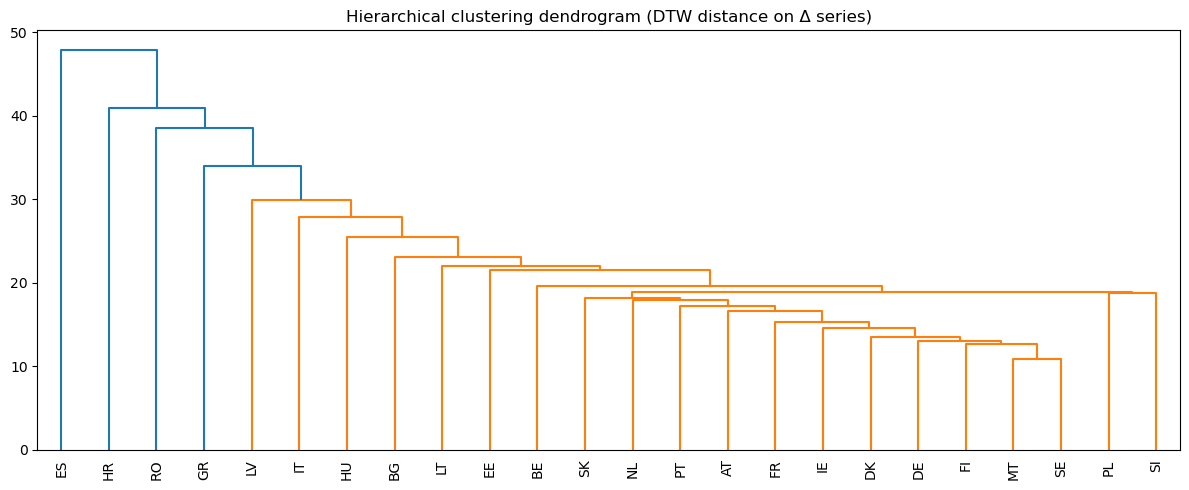

In [26]:
from scipy.spatial.distance import squareform

cluster_model = AgglomerativeClustering(n_clusters=BEST_K, metric="precomputed", linkage="average")
labels = cluster_model.fit_predict(D)

clusters = (
    pd.DataFrame({"geo": geos, "cluster": labels})
    .sort_values(["cluster", "geo"])
    .reset_index(drop=True)
)

display(clusters)

# dendrogram (SciPy linkage on condensed distance)
Z = linkage(squareform(D), method="average")

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=geos, leaf_rotation=90)
plt.title("Hierarchical clustering dendrogram (DTW distance on Δ series)")
plt.tight_layout()
plt.show()

#  8) Plot cluster mean trajectories (standardized Δ)
 We plot mean and ±1 std band for selected variables.



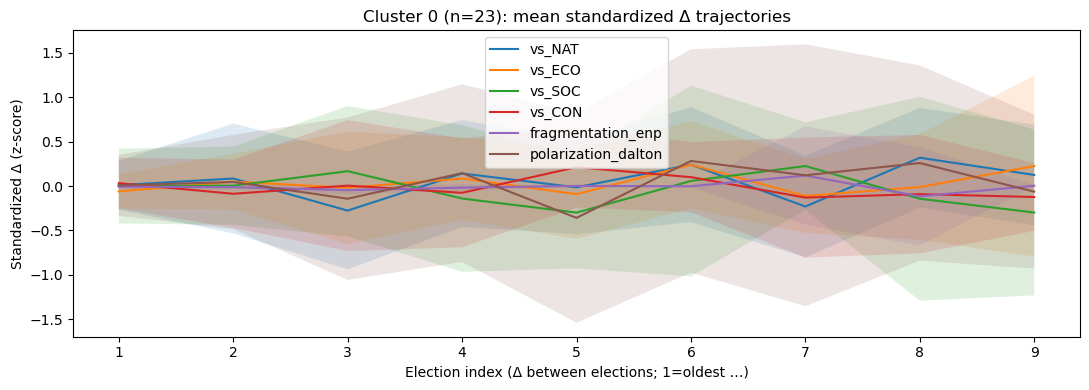

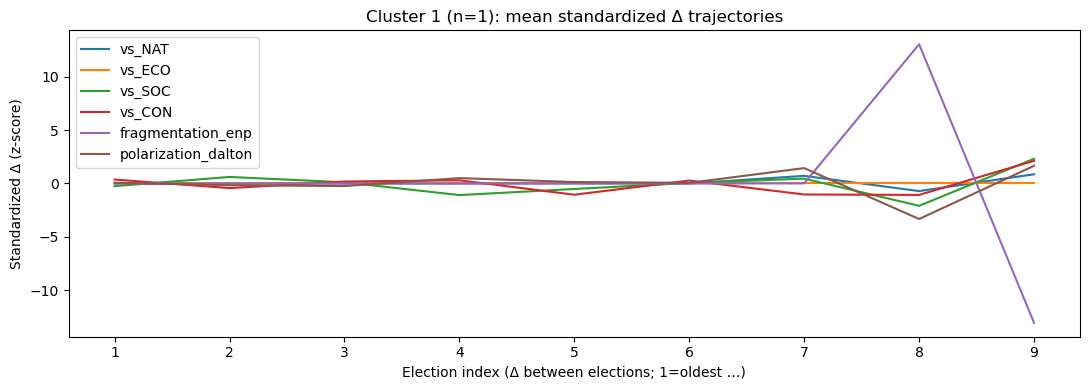

In [27]:
def plot_cluster_means(X_diff, geos, labels, feature_names, N_diff, show_cols):
    """
    X_diff: (C, T, F)  standardized differences
    """
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    idxs = [name_to_idx[c] for c in show_cols if c in name_to_idx]
    show_cols = [feature_names[i] for i in idxs]

    K = len(np.unique(labels))
    t = np.arange(1, N_diff + 1)

    for c in range(K):
        mask = labels == c
        Xc = X_diff[mask][:, :, idxs]  # (Nc, T, len(idxs))
        mean = Xc.mean(axis=0)
        std = Xc.std(axis=0)

        plt.figure(figsize=(11, 4))
        for j, col in enumerate(show_cols):
            plt.plot(t, mean[:, j], label=col)
            plt.fill_between(t, mean[:, j] - std[:, j], mean[:, j] + std[:, j], alpha=0.15)

        plt.title(f"Cluster {c} (n={mask.sum()}): mean standardized Δ trajectories")
        plt.xlabel("Election index (Δ between elections; 1=oldest …)")
        plt.ylabel("Standardized Δ (z-score)")
        plt.legend()
        plt.tight_layout()
        plt.show()


SHOW = [c for c in ["vs_NAT", "vs_ECO", "vs_SOC", "vs_CON", "fragmentation_enp", "polarization_dalton"] if
        c in cluster_cols]
plot_cluster_means(X, geos, labels, cluster_cols, X.shape[1], SHOW)

#  9) Cluster signature table (what changes most within each cluster)
- Compute mean change from earliest to latest point in the Δ series (cumulative tendency).

- Since we are clustering on Δ, a positive mean in Δ roughly indicates an "upward drift".

In [30]:
def cluster_signature_on_diff(X_diff, labels, feature_names):
    """
    Summarize each cluster by mean(Δ) over time for each feature.
    """
    rows = []
    for c in sorted(np.unique(labels)):
        mask = labels == c
        mean_drift = X_diff[mask].mean(axis=(0, 1))  # average over countries & time
        for f, name in enumerate(feature_names):
            rows.append((c, name, float(mean_drift[f])))
    return pd.DataFrame(rows, columns=["cluster", "variable", "mean_delta"])


def name_clusters(sig_df):
    """Generate descriptive names for clusters based on top changes"""
    names = {}
    for c in sig_df['cluster'].unique():
        top_changes = sig_df[sig_df['cluster'] == c].copy()
        top_changes['abs_mean_delta'] = top_changes['mean_delta'].abs()
        top_changes = top_changes.nlargest(3, 'abs_mean_delta')

        # Build name with direction indicators
        parts = []
        for _, row in top_changes.iterrows():
            var = row['variable'].replace('vs_', '')
            direction = '↑' if row['mean_delta'] > 0 else '↓'
            parts.append(f"{direction}{var}")

        names[c] = f"Cluster {c}: {', '.join(parts)}"
    return names


sig = cluster_signature_on_diff(X, labels, cluster_cols)

# Generate descriptive names
cluster_names = name_clusters(sig)

# Add names to clusters dataframe
clusters['cluster_name'] = clusters['cluster'].map(cluster_names)

# Display clusters with descriptive names
print("\n=== CLUSTERS WITH DESCRIPTIVE NAMES ===")
display(clusters)

# Show signature table with names
top_per_cluster = (
    sig.assign(abs_mean_delta=lambda d: d["mean_delta"].abs())
    .sort_values(["cluster", "abs_mean_delta"], ascending=[True, False])
    .groupby("cluster")
    .head(10)
)

print("\n=== TOP CHANGES PER CLUSTER ===")
for c in sorted(sig['cluster'].unique()):
    print(f"\n{cluster_names[c]}")
    print("-" * 60)
    cluster_data = top_per_cluster[top_per_cluster['cluster'] == c]
    display(cluster_data[['variable', 'mean_delta']].reset_index(drop=True))



=== CLUSTERS WITH DESCRIPTIVE NAMES ===


,geo,cluster,cluster_name
0,AT,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
1,BE,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
2,BG,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
3,DE,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
4,DK,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
5,EE,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
6,FI,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
7,FR,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
8,GR,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"
9,HR,0,"Cluster 0: ↓SOC, ↑SIP, ↑NAT"



=== TOP CHANGES PER CLUSTER ===

Cluster 0: ↓SOC, ↑SIP, ↑NAT
------------------------------------------------------------


,variable,mean_delta
0,vs_SOC,-0.047540
1,vs_SIP,0.045354
2,vs_NAT,0.044331
3,vs_ECO,0.033882
4,polarization_dalton,0.032946
5,vs_CHR,-0.023218
6,vs_CON,-0.017640
7,vs_LIB,0.016286
8,vs_DIV,0.012354
9,vs_AGR,-0.010645



Cluster 1: ↑NAT, ↓SOC, ↓CON
------------------------------------------------------------


,variable,mean_delta
0,vs_NAT,0.095667
1,vs_SOC,-0.045785
2,vs_CON,-0.038669
3,vs_ETH,0.022620
4,polarization_dalton,0.013029
5,vs_LEF,-0.006149
6,fragmentation_enp,0.000576
7,vs_AGR,0.000000
8,vs_CHR,0.000000
9,vs_DIV,0.000000


#  10) Inspect raw election-time series for countries in a cluster



Cluster 0: ↓SOC, ↑SIP, ↑NAT
Members (23): AT, BE, BG, DE, DK, EE, FI, FR, GR, HR, HU, IE, IT, LT, LV, MT, NL, PL, PT, RO, SE, SI, SK



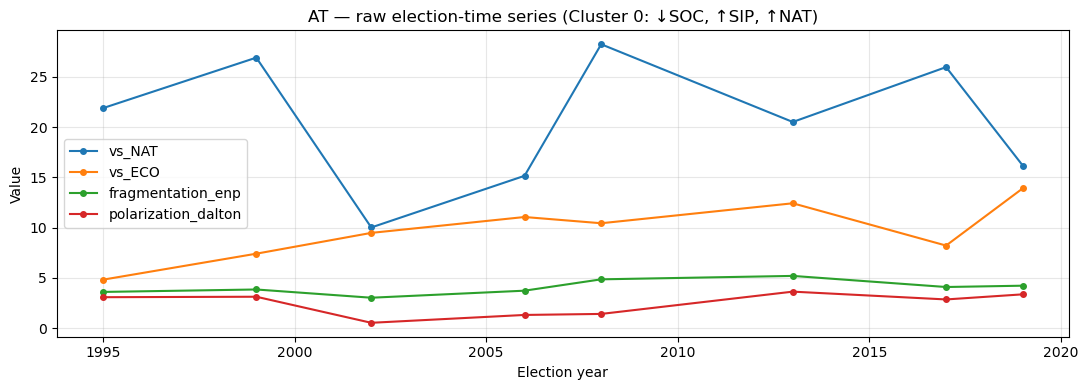

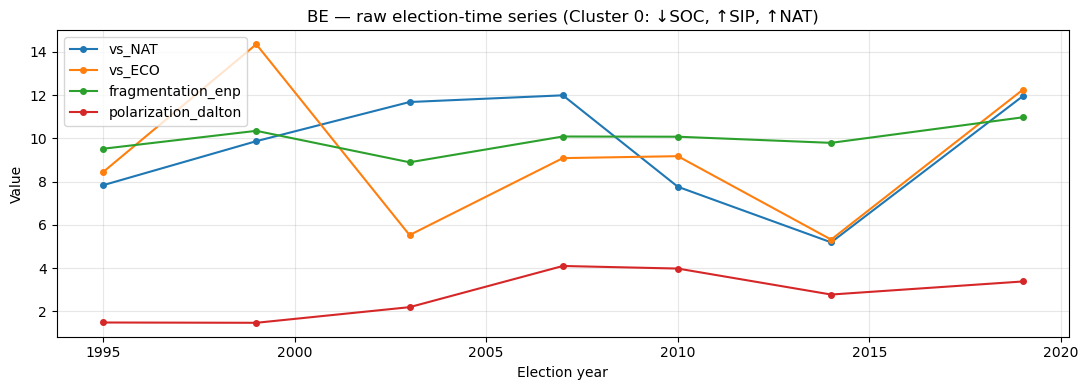

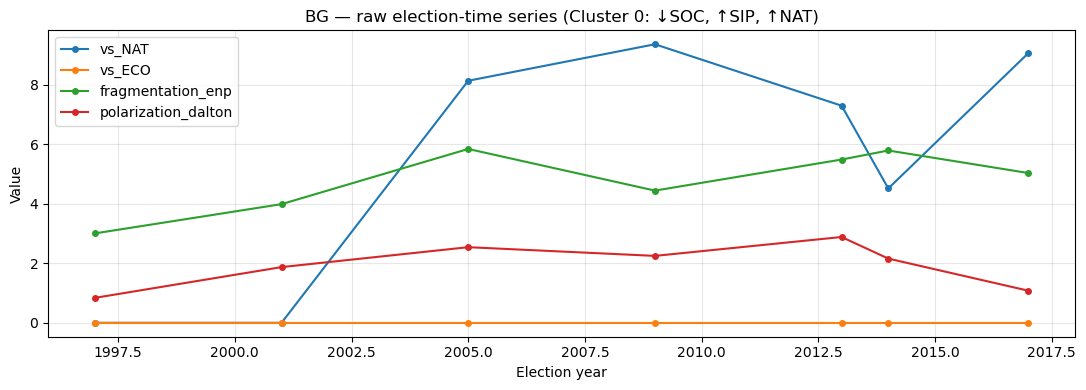

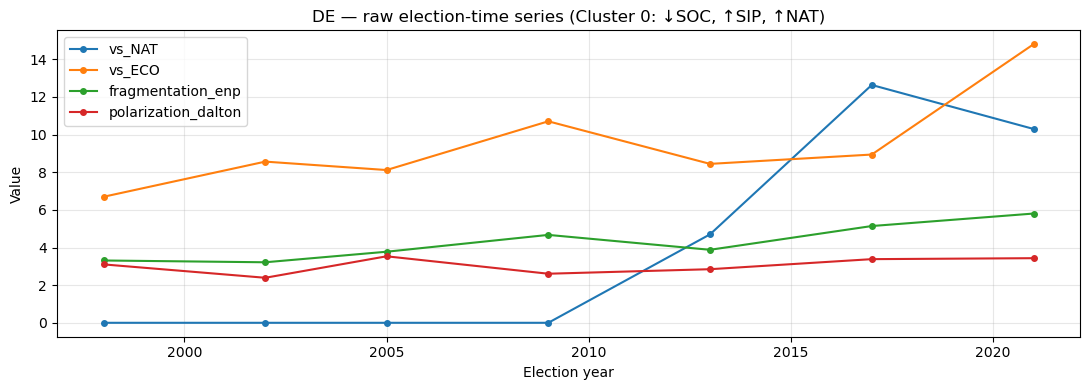

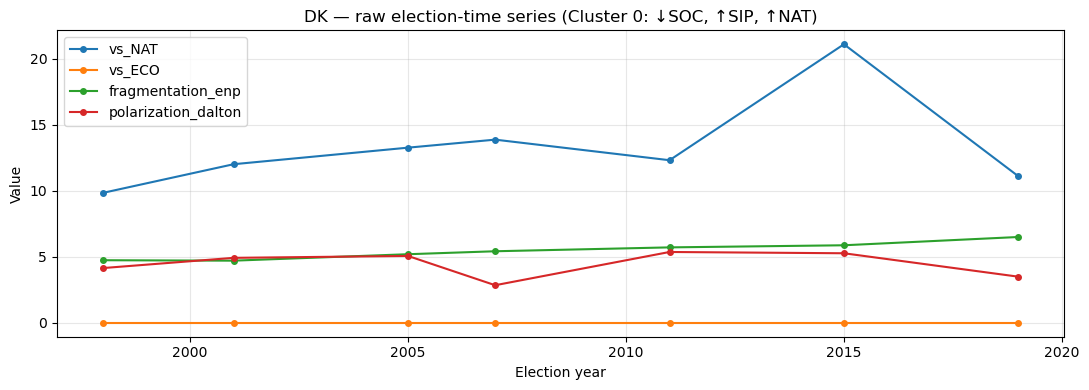

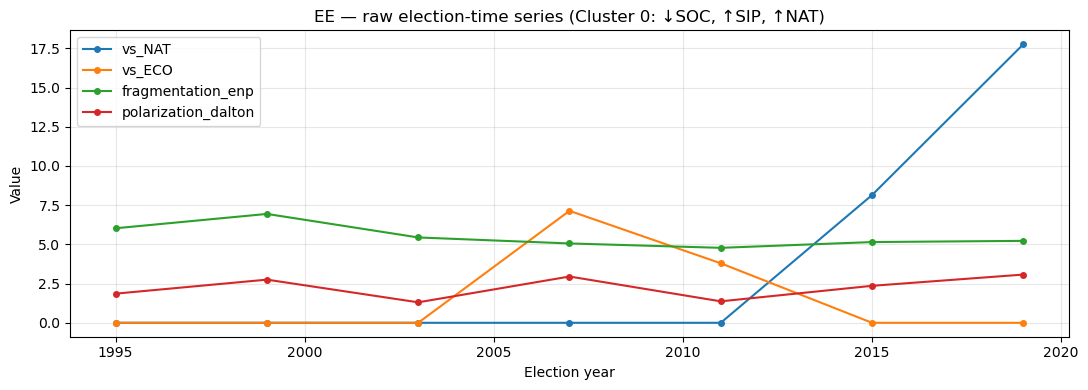

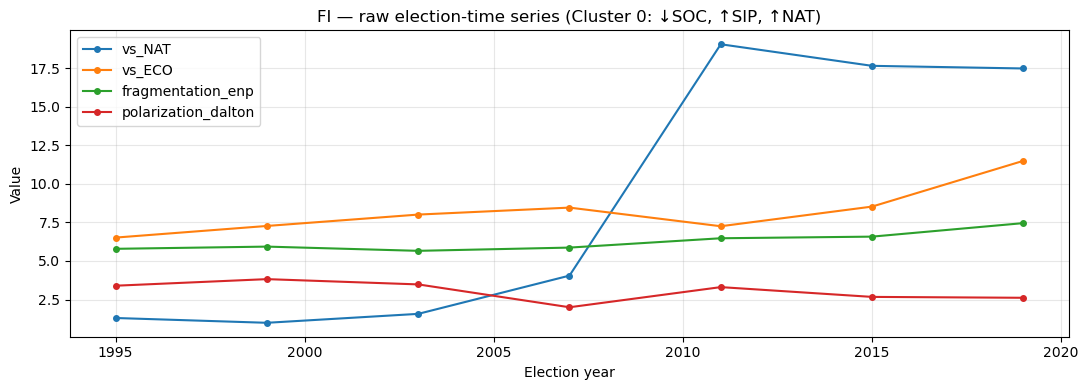

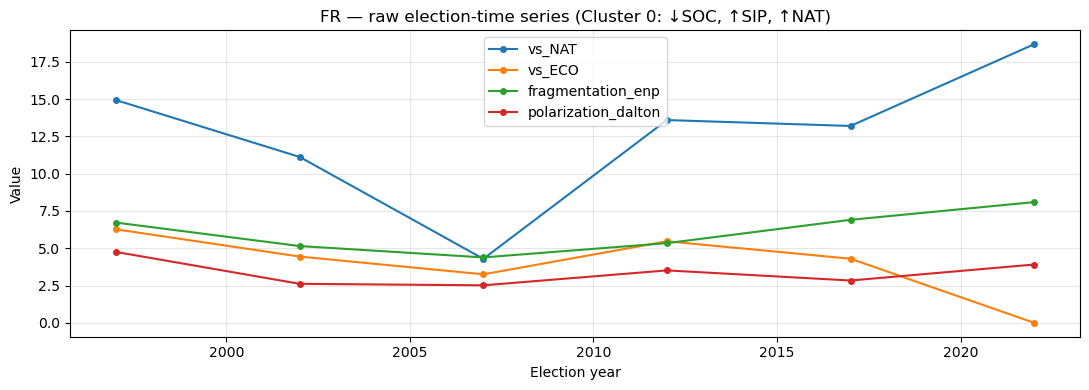

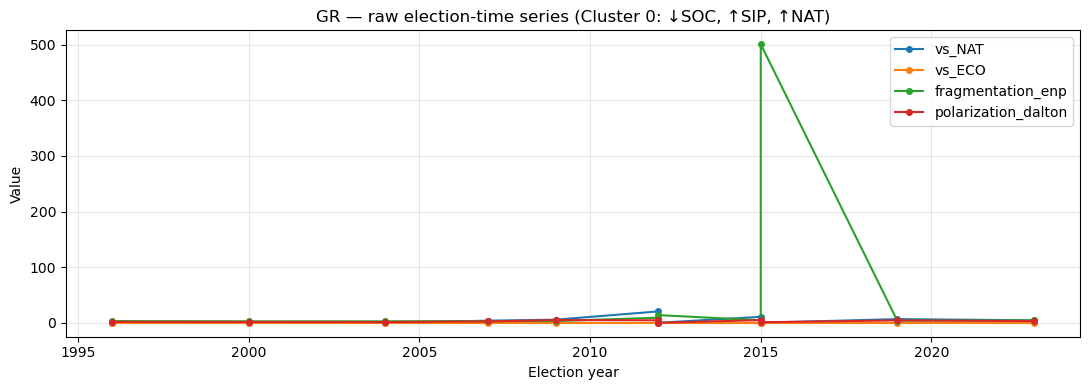

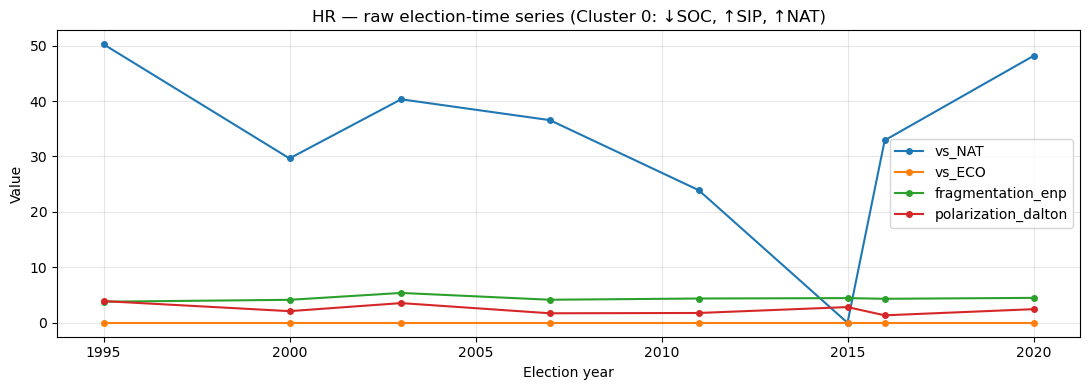

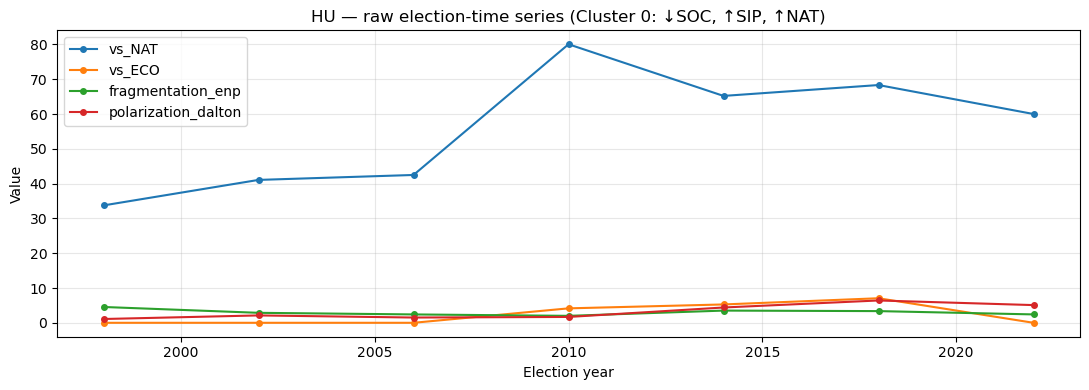

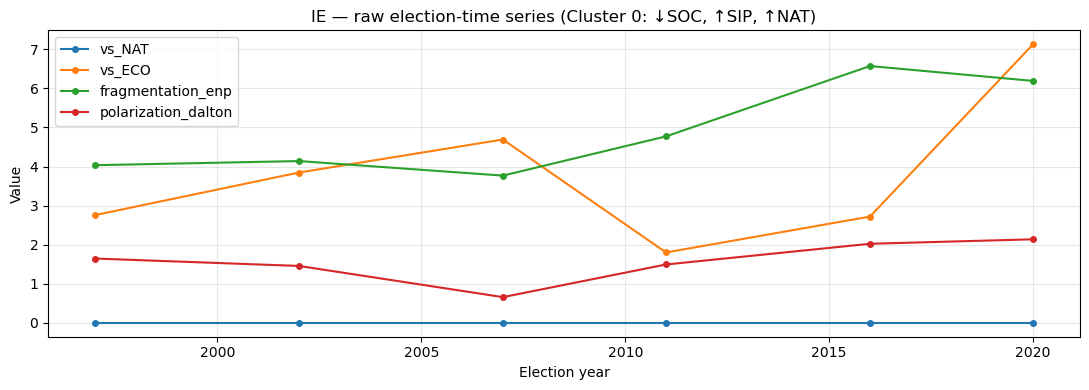

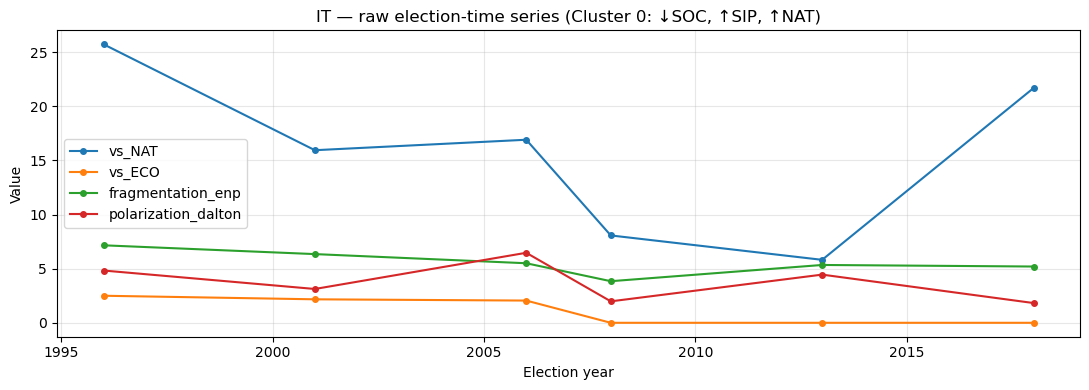

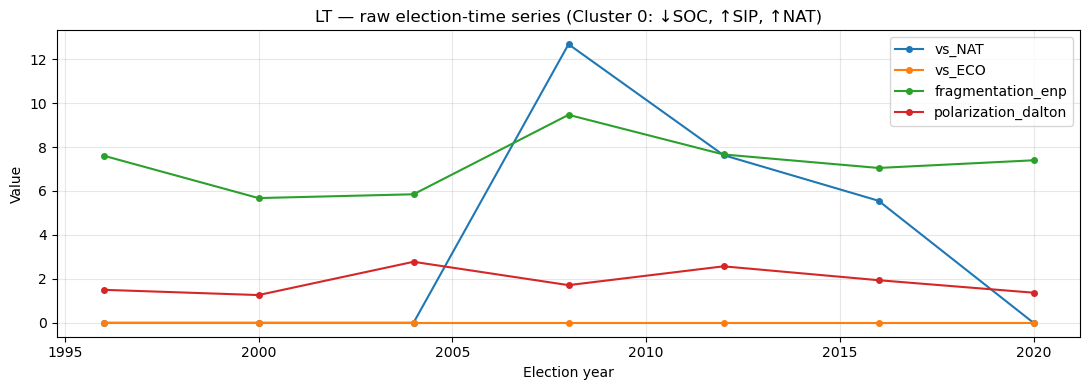

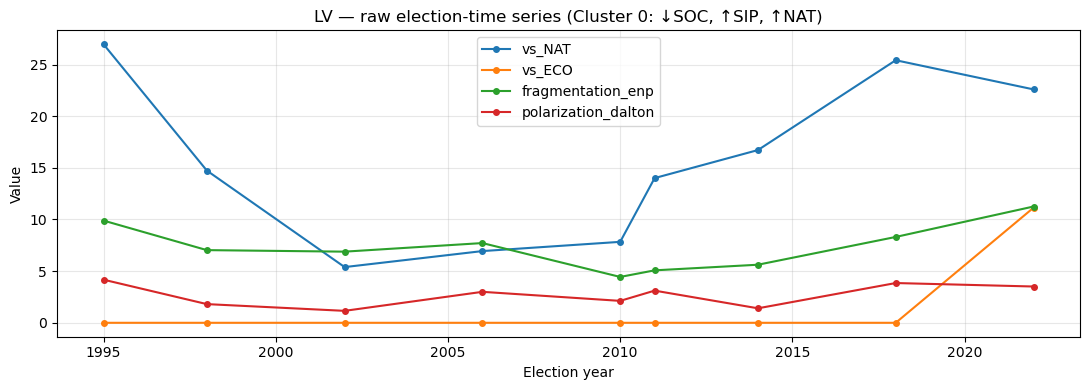

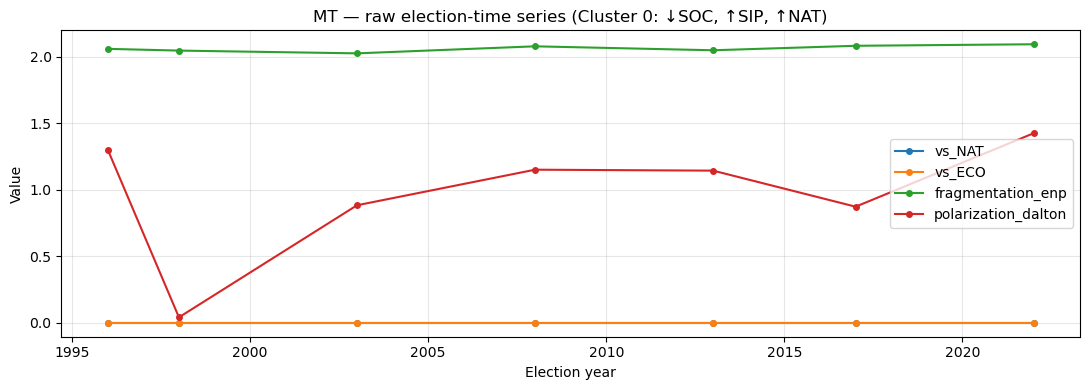

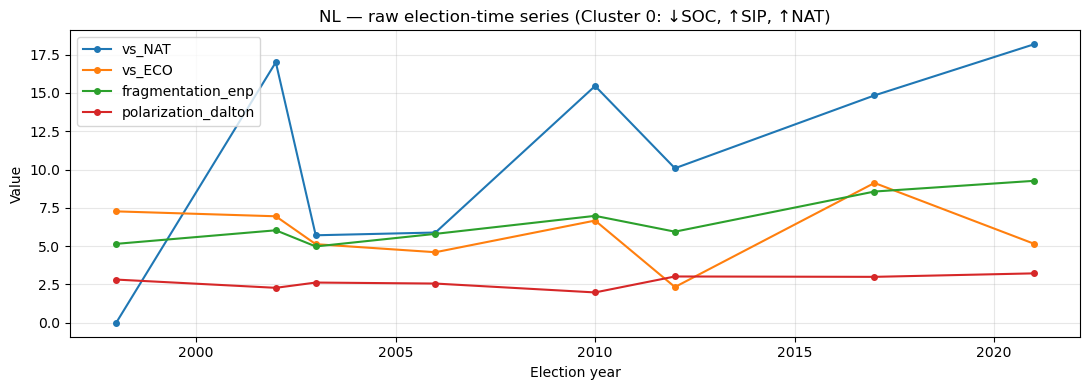

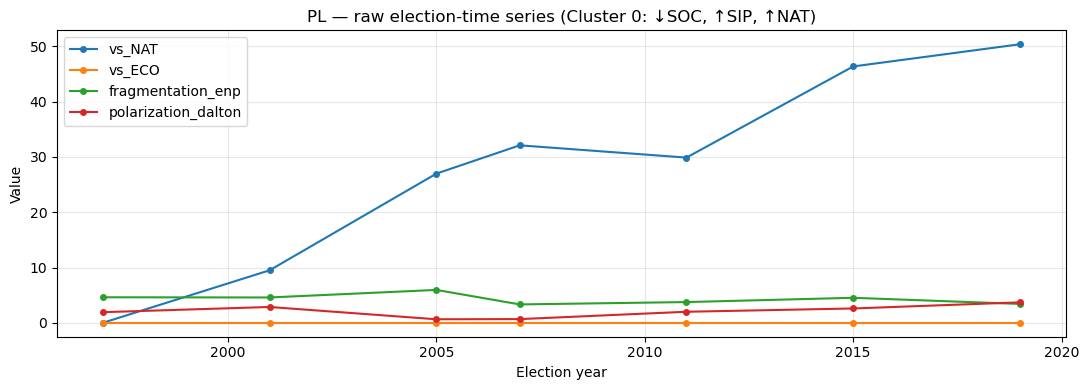

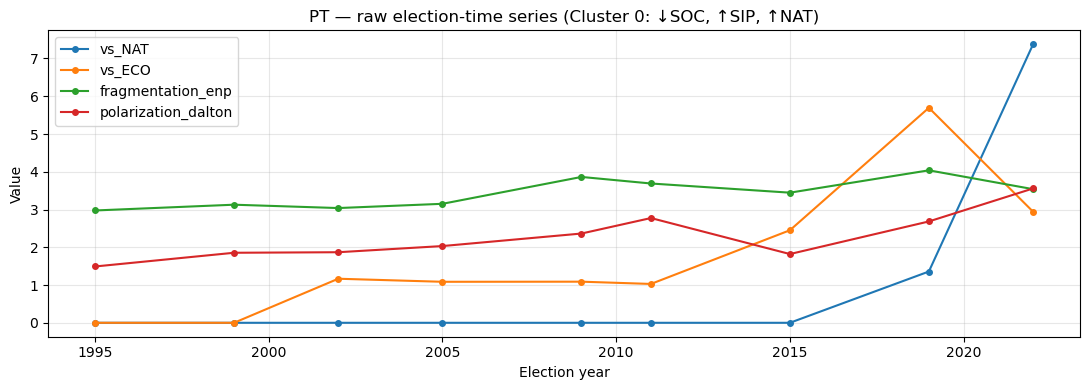

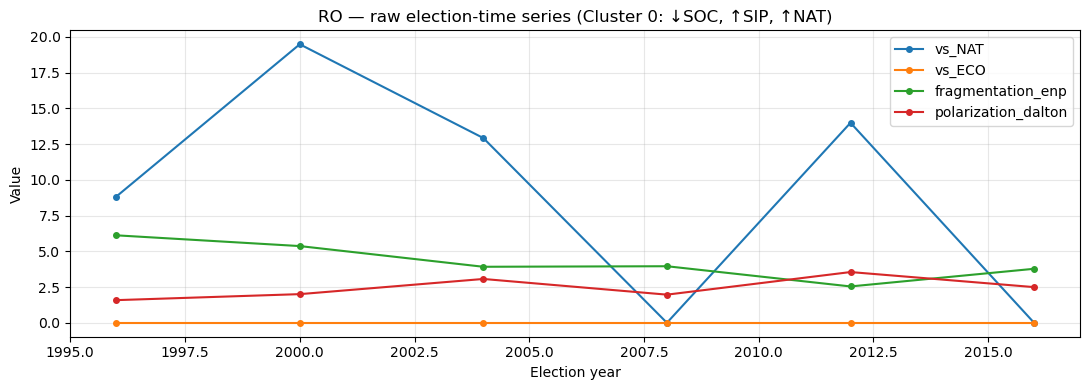

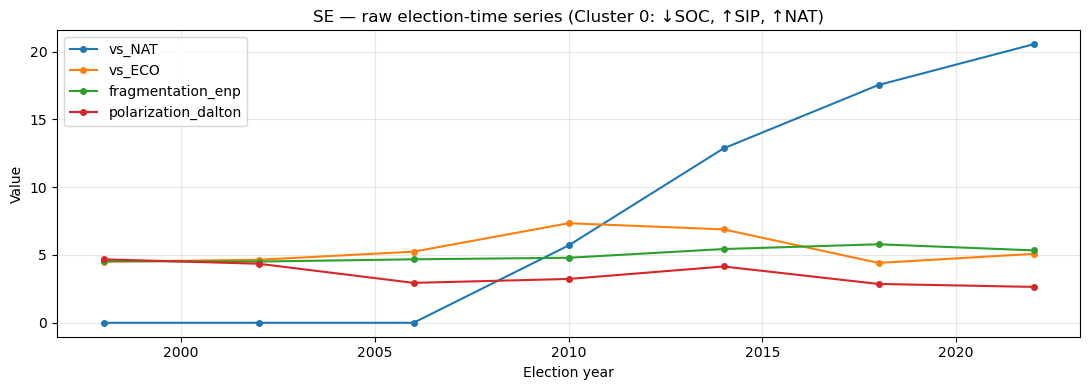

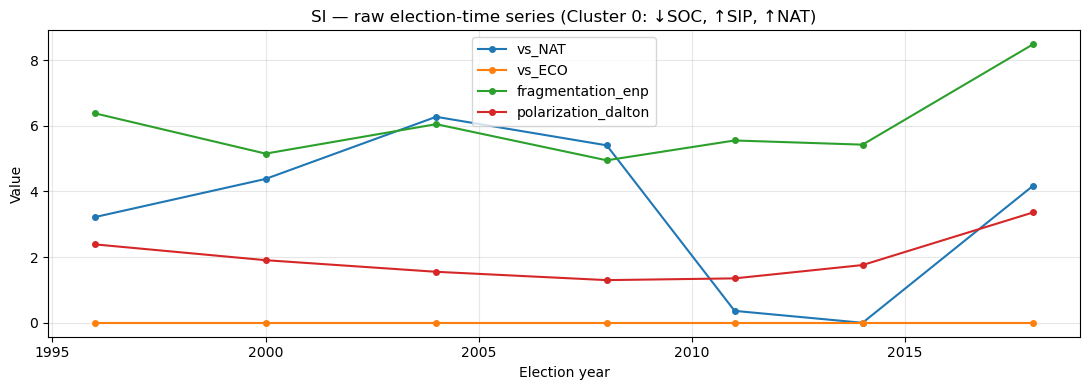

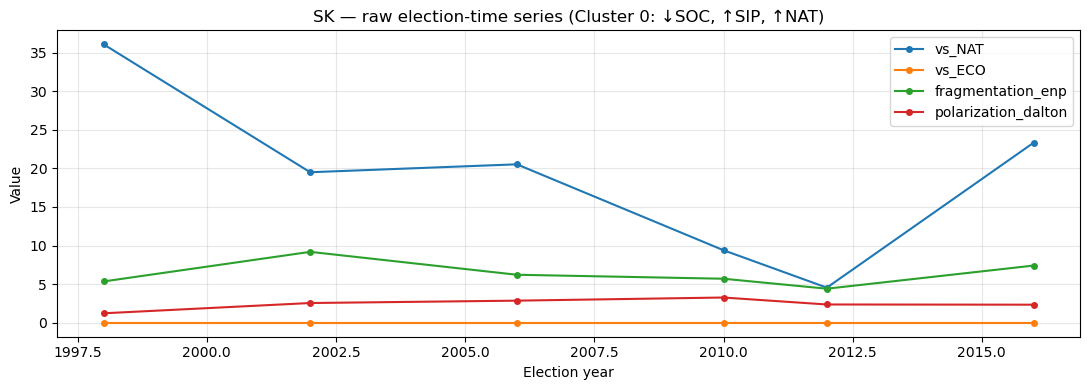

In [31]:
def plot_countries_in_cluster(cluster_id, elections_df, clusters_df, cluster_names_dict, cols_to_plot=None):
    """
    Plot raw time series for all countries in a given cluster.
    Now includes descriptive cluster name in output.
    """
    if cols_to_plot is None:
        cols_to_plot = ["vs_NAT", "vs_ECO", "fragmentation_enp", "polarization_dalton"]
        cols_to_plot = [c for c in cols_to_plot if c in elections_df.columns]

    members = clusters_df.loc[clusters_df["cluster"] == cluster_id, "geo"].tolist()
    cluster_name = cluster_names_dict.get(cluster_id, f"Cluster {cluster_id}")

    print(f"\n{'='*70}")
    print(f"{cluster_name}")
    print(f"Members ({len(members)}): {', '.join(sorted(members))}")
    print(f"{'='*70}\n")

    for geo in members:
        g = elections_df.loc[geo].sort_index()
        plt.figure(figsize=(11, 4))
        for c in cols_to_plot:
            plt.plot(g.index, g[c], label=c, marker='o', markersize=4)
        plt.title(f"{geo} — raw election-time series ({cluster_name})")
        plt.xlabel("Election year")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Example usage with names:
plot_countries_in_cluster(0, elections, clusters, cluster_names,
                          cols_to_plot=["vs_NAT","vs_ECO","fragmentation_enp","polarization_dalton"])

#  11) Cluster overview visualization

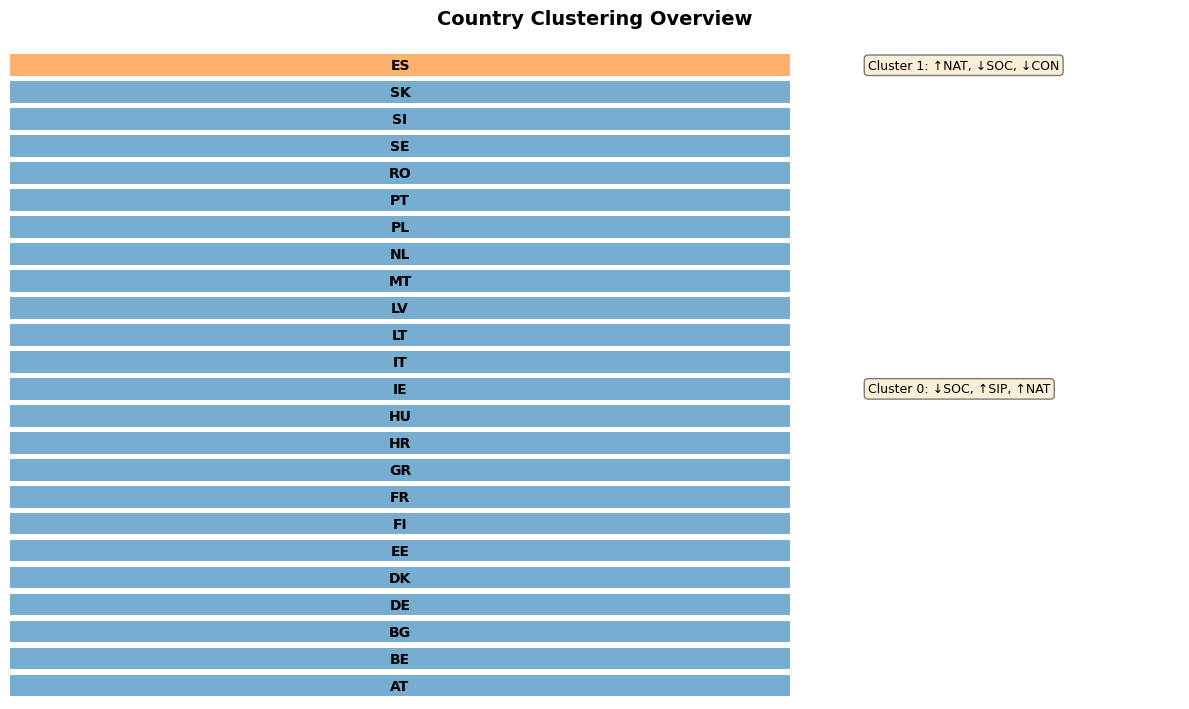

In [34]:
def plot_cluster_overview(clusters_df, cluster_names_dict):
    """
    Create a visual overview of all clusters with their countries.
    """
    # Reset index to get numeric positions
    clusters_plot = clusters_df.reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, max(6, len(clusters_plot) * 0.3)))

    for idx, row in clusters_plot.iterrows():
        cluster_id = row['cluster']
        color = plt.cm.tab10(cluster_id % 10)
        ax.barh(idx, 1, color=color, alpha=0.6)
        ax.text(0.5, idx, f"{row['geo']}",
                ha='center', va='center', fontsize=10, weight='bold')

    # Add cluster labels on the right
    for c in sorted(clusters_plot['cluster'].unique()):
        members_indices = clusters_plot[clusters_plot['cluster'] == c].index.tolist()
        y_pos = np.mean(members_indices)
        ax.text(1.1, y_pos, cluster_names_dict[c],
                ha='left', va='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_xlim(0, 1.5)
    ax.set_ylim(-0.5, len(clusters_df) - 0.5)
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Country Clustering Overview', fontsize=14, weight='bold', pad=20)

    plt.tight_layout()
    plt.show()

plot_cluster_overview(clusters, cluster_names)

"Our time-series clustering identified a dominant pan-European trajectory (24/25 countries) characterized by declining social democratic parties and rising nationalist and special-issue movements. Spain represents an intensified version of this pattern, distinguished by the simultaneous collapse of both traditional establishment parties rather than just the center-left. This high degree of convergence suggests common underlying socioeconomic drivers, which our correlation and regression analyses explore."

